# Data Drift Monitoring with Giskard

## Introduction

Every machine learning model is trained to capture and interpret patterns in data to make predictions. A critical aspect of this process is understanding how each feature in our dataset follows a specific distribution. Let’s consider an example: predicting the number of people visiting a library based on their age.

In the figure below, the leftmost plot shows the age distribution used for training our model. We observe that most visitors are between the ages of 50-70. However, once the model is deployed in a live production environment and we begin collecting new data, a shift occurs. The middle plot illustrates that the age group of visitors has shifted to predominantly 20-50 years. This shift leads to our model underpredicting the count for this age group, signaling a degradation in model performance.

The rightmost plot highlights a notable drift in the distribution of the Age feature. The mean age in the original dataset (blue plot) is around 58, whereas in the new data (orange plot), it is closer to 32. This change exemplifies data drift.

![Age Distribution](./images/age-distribution.png)

More formally, **data drift occurs when the statistical properties of the data used to train a machine learning model change over time**. This means that the data the model is currently processing differs from the data it was trained on, potentially impacting its accuracy. 

### Why is Data Drift Important?

Data drift can significantly impact a model's performance, similar to a professional football player suddenly being asked to play cricket without any additional training. The model, like the athlete, struggles when the type of data it 'understands' changes, leading to decreased accuracy and effectiveness.

Understanding and monitoring this drift is crucial for maintaining the efficacy of machine learning models in dynamic environments. Giskard offers tools to identify and address these changes, ensuring that models remain reliable and accurate over time.

Before diving deeper, let’s preview what this tutorial will cover:

- Types of Data Drift – Understanding the different types of data drift.
- Drift Tests available in Giskard – Exploring the drift tests available in Giskard.
- Building Test Suites for Various Use Cases – Creating test suites to monitor data drift in different scenarios.
- Input Feature vs/& Prediction Drift – Understanding the relationship and differences between input feature drift and prediction drift.

## Types of Data Drift

There are two primary types of drifts in data:

### 1. Concept Drift

Concept drift is identified when the relationship between the input data and the output undergoes a change over time. This alteration implies that even though the input data appears consistent, its interpretation or the predicted outcome it leads to is different from before.

This phenomenon can be categorized into four types, as outlined in "Learning under Concept Drift: A Review" by Jie Lu et al.:

- Sudden Drift: This is characterized by an abrupt change in data patterns, where the new data distribution differs significantly from the old one.
- Gradual Drift: Here, the data evolves slowly over time, leading to a gradual change in the model's performance.
- Incremental Drift: This involves a progressive shift in the data, where the change is neither sudden nor gradual but occurs incrementally.
- Recurring Concepts: In this case, previously seen data patterns re-emerge over time, requiring the model to re-adapt to known conditions.

![Concept Drift Cateogries](./images/concept-drift-categories.png "Source: https://arxiv.org/pdf/2004.05785.pdf")

### 2. Covariate Drift

Covariate drift refers to changes in the distribution of the input variables (covariates) of the model, without any change in the relationship between input and output.

### Conceptual Difference
- **Change in Relationship vs. Change in Data**: The key difference lies in what changes. In concept drift, the fundamental relationship between input and output changes. In covariate drift, the relationship stays the same, but the type or range of input data the model sees has changed.

- **Adaptation Strategies**: Addressing concept drift often requires retraining the model with new data that reflects the changed relationships. For covariate drift, ensuring that the model is exposed to and trained on a representative range of input data is crucial.

**In this tutorials we'll be focusing on exploring various tests used for detecting covariate drift.**

## Different Data Drifts test in Giskard

There are four types of tests available in Giskard for both input features and target variable:

### 1. Kolmogorov-Smirnov Test (KS test)

The KS Test is a non-parametric method used to compare two sample distributions to assess if they originate from the same underlying population distribution. Its non-parametric nature makes it suitable for all distribution types, without needing the sample data to adhere to for instance a normal distribution.

This test is **only applicable to numeric data types**, such as float and int.

A key outcome of the KS test is the p-value. A p-value below 0.05 usually indicates strong evidence against the null hypothesis, suggesting that the samples are drawn from different distributions. However, it's important to remember that the p-value is an indicator of the test's statistical significance and not a direct measure of drift magnitude.

In our experiments, we use a default significance level of 0.95. Therefore, a p-value less than 0.05 is treated as an indication of data drift. You can change the significance level based on your use case.

### 2. Chi-Square Test

The Chi-Square Test checks if the actual data (observed frequencies) matches what we would typically expect (expected frequencies). It helps us figure out if any differences are just by chance or if they're important and meaningful.

The Chi-Square Test can be particularly useful for evaluating if **changes in the distributions of categorical data are significant**. It compares the new data with what was expected from the old data. 

### 3. Population Stability Index (PSI)

The Population Stability Index (PSI) is a widely used tool for detecting data drift in **numerical and categorical data**. Unlike tests that yield a p-value, PSI generates a number that begins at 0 and can increase indefinitely. This number is useful not just for identifying the presence of drift, but also for gauging its magnitude - the greater the PSI value, the more pronounced the difference in distributions.

For drift detection, we identify a notable drift in features when the PSI exceeds 0.2.

### 4. Earth-Mover Distance (Wasserstein distance)

The Earth Mover's Distance (EMD) is used to measure the difference between two distributions, or how one distribution differs from another. This test is **applicable to numeric data types**. To understand it in simple terms, let's use an analogy:

Imagine you have two piles of dirt representing two different distributions. Each pile has various amounts of dirt at different locations. Now, your task is to reshape the first pile to make it look exactly like the second pile.

The Earth Mover's Distance is like measuring the least amount of work you need to do to accomplish this. In this context, "work" refers to how much dirt you move and how far you move it. If the piles are very similar to begin with, you won't have to move much dirt very far, so the EMD will be small. But if they're very different, you'll have to do a lot more work, moving lots of dirt over greater distances, resulting in a larger EMD.

For drift detection, a threshold of 0.1 is set, meaning that changes amounting to 0.1 standard deviations are significant enough to be noted.

## Monitoring in Action

We'll start off by implementing individual tests and then move on to building test suites which are a collection of tests.

### About the Dataset

We'll be using the [Bike Sharing Dataset](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) from UCI Machine Learning Repository. The dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. We'll be using the daily dataset for this tutorial.

### Setup

If you haven't installed giskard already, you can do so by running the following command:

```bash
pip install giskard -U
```

### Importing Libraries

We'll be using the following libraries for this tutorial:

In [2]:
import pandas as pd
import requests
import zipfile
import io
import warnings
import matplotlib.pyplot as plt

from giskard import Dataset, Model, testing, Suite
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
%matplotlib inline

/Users/wizard/anaconda3/lib/python3.9/site-packages/giskard/core/validation.py:31: RuntimeWarning: fields may not start with an underscore, ignoring "_args"
  validated_func = validate_arguments(func, config={"arbitrary_types_allowed": True})
/Users/wizard/anaconda3/lib/python3.9/site-packages/giskard/core/validation.py:31: RuntimeWarning: fields may not start with an underscore, ignoring "_kwargs"
  validated_func = validate_arguments(func, config={"arbitrary_types_allowed": True})


### Downloading the Dataset

We'll be downloading the dataset from the UCI Machine Learning Repository using the following code:

In [3]:
url = "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip"
content = requests.get(url).content
with zipfile.ZipFile(io.BytesIO(content)) as handle:
    raw_data = pd.read_csv(handle.open('day.csv'), header=0, sep=',', parse_dates=['dteday'])

### Creating the Dataset

For simplicity we'll drop the following columns to `instant`, `dteday`, `casual`, and `registered`.

The idea behind the monitoring is that we have some reference data (past training data) and current data (production data or new data), we want to verify how much change do we observe in the distribution of these two dataset.

Again for simplicity since we don't have a system in place to get production data, we'll split our dataset in some fashion to mimic these two dataset.

Since, we're using giskard for monitoring we need convert our pandas dataframe to a giskard `Dataset`` object.

In [4]:
# Drop some columns for simplicity
raw_data = raw_data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Pick 100 rows for each dataset: reference and current
reference_dataset = raw_data.iloc[-200:-100]
current_dataset = raw_data.iloc[-100:]

# Some boiler plate config variables
CAT_COLS = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
NUM_COLS = ['temp', 'atemp', 'hum', 'windspeed']
TARGET_COL = 'cnt'

# Wrap our two dataset in Giskard Dataset
wrapped_ref_dataset = Dataset(
    df=reference_dataset,
    target=TARGET_COL,
    cat_columns=CAT_COLS
)

wrapped_curr_dataset = Dataset(
    df=current_dataset,
    target=TARGET_COL,
    cat_columns=CAT_COLS
)

<!-- # We'll give the Giskard Dataset an attribute for numeric columns
# This will simply the downstream tasks

wrapped_ref_dataset.num_columns = NUM_COLS
wrapped_curr_dataset.num_columns = NUM_COLS -->

Now that we have our dataset ready, we can start implementing the tests.

### Perform Test on a Single Feature

We'll start off by implementing the test on a single feature. Since, each test in giskard works on a single feature at a time. We'll be using the `temp` feature and perform the KS test on it.

Each test in giskard is under the `testing` module. We'll be using the `test_drift_ks` method to perform the KS test. It takes the following arguments:

- `actual_dataset`: The current dataset
- `reference_dataset`: The reference dataset
- `column_name`: The column name on which the test will be performed
- `threshold`: The threshold value for the test (default value is 0.05). We can adjust this value based on the significance level we want.

If the threshold is set to 0.05, the test fails when the p-value of the KS test of the numerical variable between the actual and reference datasets is less than 0.05.

In [5]:
TEST_COL = 'temp'
THRESHOLD = 0.05

temp_ks_test = testing.test_drift_ks(
    actual_dataset=wrapped_curr_dataset,
    reference_dataset=wrapped_ref_dataset,
    column_name=TEST_COL,
    threshold=THRESHOLD # Default value 0.05
)

result = temp_ks_test.execute()

print("Result for 'Classification Probability drift (Kolmogorov-Smirnov):")
print(f"Passed: {result.passed}")
print(f"Metric: {result.metric:.3f}")
print(f"Threshold: {THRESHOLD}")

Result for 'Classification Probability drift (Kolmogorov-Smirnov):
Passed: False
Metric: 0.000
Threshold: 0.05



### Perform Test on Multiple Features (Test Suite)

Now that we have implemented the test on a single feature, we can move on to implementing the test on multiple features. We'll be using the `temp` and `workingday` features.

We'll be using the `Suite` class from the `giskard` library to implement the test suite. It is also possible to add multiple tests on a single feature. To run the test suite we can use the `run` method.

In [6]:
suite = (
    Suite()                                         # Create a test suite
    .add_test(                                      # Add test to suite
        testing.test_drift_ks(
            actual_dataset=wrapped_curr_dataset,
            reference_dataset=wrapped_ref_dataset,
            column_name='temp'
        )
    )
    .add_test(                                      # Add test to suite
        testing.test_drift_chi_square(
            actual_dataset=wrapped_curr_dataset,
            reference_dataset=wrapped_ref_dataset,
            column_name='workingday'
        )
    )
)

suite_results = suite.run()
suite_results

Executed 'Numerical drift (Kolmogorov-Smirnov)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'temp'}: 
               Test failed
               Metric: 0.0
                - [TestMessageLevel.ERROR] The data is drifting (p-value is equal to 0.0 and is below the test risk level 0.05) 
               
Executed 'Categorical drift (Chi-squared)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'workingday'}: 
               Test succeeded
               Metric: 0.67
                - [TestMessageLevel.ERROR] The data is drifting for the following modalities: [,0,,, ,1,]
               


<TestSuiteResult (failed)>


### Perform Test on All Features

We can also perform the test on all the features in our dataset. We'll define some utility functions to help us with this.

The `_check_test` function is used to check the type of the feature and based on the type of the feature it will return the appropriate test. We have also added a `prediction_flag` argument which will be used to determine if we want to perform the test on the target variable or not. Also, we've some conditional logic to determine which test to use based on the number of rows in the dataset. We'll cover why we have this logic in the next section.

The `test_drift_dataset_suite` function is used to create the test suite. It takes the following arguments:

- `suite_name`: The name of the test suite
- `cols`: The list of columns on which the test will be performed
- `wrapped_ref_dataset`: The reference dataset
- `prediction_col_type`: The type of the target variable (default value is None)
- `prediction_col`: The name of the target variable (default value is None)

In [7]:
def _check_test(col_type: str, 
                column_name: str, 
                num_rows: int, 
                prediction_flag: bool = False, 
                NUM_ROWS_THRESHOLD: int = 1000):
    
    is_small_dataset = num_rows <= NUM_ROWS_THRESHOLD
    drift_test_function = None

    if col_type == 'numeric':
        if is_small_dataset:
            drift_test_function = testing.test_drift_prediction_ks if prediction_flag else testing.test_drift_ks
        else:
            drift_test_function = testing.test_drift_prediction_earth_movers_distance if prediction_flag else testing.test_drift_earth_movers_distance

    elif col_type == 'categorical':
        if is_small_dataset:
            drift_test_function = testing.test_drift_prediction_psi if prediction_flag else testing.test_drift_psi
        else:
            drift_test_function = testing.test_drift_prediction_chi_square if prediction_flag else testing.test_drift_chi_square

    if drift_test_function:
        return drift_test_function(column_name=column_name)

    raise ValueError(f"Unsupported column type: {col_type}")

def test_drift_dataset_suite(suite_name: str,
                             cols: list,
                             wrapped_ref_dataset: Dataset,
                             prediction_col_type: str = None,
                             prediction_col: str = None):
    N = len(wrapped_ref_dataset.df)

    suite = Suite(name=suite_name)

    for col in cols:
        if col in wrapped_ref_dataset.category_features.keys():
            test = _check_test('categorical', col, N)
        else:
            test = _check_test('numeric', col, N)
        
        suite.add_test(test)

    if prediction_col is not None:
        test = _check_test(prediction_col_type, prediction_col, N, True)
        suite.add_test(test)

    return suite

Now that we have our utility functions ready, we can create our test suite.

In [10]:
all_features_drift_suite = test_drift_dataset_suite('all_features_drift_test',
                                                    CAT_COLS + NUM_COLS,
                                                    wrapped_ref_dataset)

all_features_drift_suite_result = all_features_drift_suite.run(actual_dataset=wrapped_curr_dataset,
                                                               reference_dataset=wrapped_ref_dataset)
all_features_drift_suite_result

Executed 'Categorical drift (PSI)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'season'}: 
               Test failed
               Metric: 17.84
                - [TestMessageLevel.ERROR] The data is drifting for the following modalities: [,3,,, ,4,]
               
Executed 'Categorical drift (PSI)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'yr'}: 
               Test succeeded
               Metric: 0.0
               
               
Executed 'Categorical drift (PSI)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'mnth'}: 
               Test failed
             

<TestSuiteResult (failed)>

2023-12-20 02:00:25,039 pid:78951 Thread-16 urllib3.connectionpool WARNING  Connection pool is full, discarding connection: api.mixpanel.com. Connection pool size: 10


Below image shows some part of the output of the test suite. 

--- Insert Output Image ---

Something to note here is that while creating the tests we don't have to specify the `actual_dataset` and `reference_dataset` arguments (Observe in the `_check_test` method). We can pass these arguments while running the test suite using the `run` method.

Why is this useful? Let's say we want to periodically run the test suite on our production data. We can simply create the test suite and save it somewhere. Then we can load the test suite and run it on every batch of data we get from production. We are not restricted to run the test suite on the dataset we used to create the test suite.

Isn't that cool?

### Drift Test at Dataset Level

Individual tests and tests in a test suite tell us if there is a drift in a particular feature. But what if we want to know if there is a drift in the dataset as a whole?

The idea is if you have a dataset with 10 features and more than 5 features have drifted, we can say that the dataset has drifted. We can use the following function to implement this logic:


In [12]:
def dataset_drift_test(test_suite_results: list,
                       threshold: float = 0.5):

    raw_results = test_suite_results
    count, N = 0, len(raw_results)

    for result in raw_results:
        if 'succeed' in str(result[1]): count += 1
    passed = (count / N) > threshold

    return {
        'passed': passed,
        'metric': (count / N)
    }

dataset_drift_test(all_features_drift_suite_result.results)

{'passed': True, 'metric': 0.5454545454545454}

We can adjust the `threshold` value based on our usecase. If we want to be more strict we can set the threshold to 0.8 or 0.9. If we want to be more lenient we can set the threshold to 0.3 or 0.4.

The `results` attribute provides a list of tuples. Each tuple contains the name of the test, result of the test, and other information.

### Determine with Test based on some Condition

We have multiple tests available for both numeric and categorical features. But how do we determine which test to use for a particular feature?

The tests performance can vary based on the number of rows in the dataset, the type of the feature, assumptions about the underlying distribution of the feature, etc. For instance, the KS test is a non-parameteric test and it works across all types of distribution. But the Chi-Square test assumes that the feature follows a normal distribution.

To demonstrate this, we defined the `_check_test` function earlier in this tutorial. The function returns the appropriate test based on the type of the feature and the number of rows in the reference datset. We can also add more logic to this function based on our usecase.

### Drift Test for Prediction Drift

We can also perform the drift test on the target variable. We'll be using the `cnt` feature for this tutorial.

In giskard to perform drift on the target variable we need the model that was used to train the model. We'll be using the `Model` class from the `giskard` library to create a model.

For simplicity we'll be using a linear regression model and 100 rows from our dataset to train the model. Once, we have the model we can use the `prediction_function` to wrap the model and create a Giskard `Model` object.

In [13]:
train = raw_data.iloc[:100]

lr = LinearRegression()

lr.fit(train.drop('cnt', axis=1), train.cnt)

def prediction_function(df):
    return lr.predict(df)

giskard_model = Model(
    model=prediction_function,
    model_type="regression"
)

Let's create a test suite to test the features and the target variable.

In [17]:
feature_target_drift_suite = test_drift_dataset_suite('feature_target_drift_test',
                                                    CAT_COLS + NUM_COLS,
                                                    wrapped_ref_dataset,
                                                    prediction_col_type='numeric',
                                                    prediction_col=TARGET_COL)

feature_target_drift_suite_results = feature_target_drift_suite.run(actual_dataset=wrapped_curr_dataset,
                                                                    reference_dataset=wrapped_ref_dataset,
                                                                    model=giskard_model)

Executed 'Categorical drift (PSI)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'season'}: 
               Test failed
               Metric: 17.84
                - [TestMessageLevel.ERROR] The data is drifting for the following modalities: [,3,,, ,4,]
               
Executed 'Categorical drift (PSI)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'yr'}: 
               Test succeeded
               Metric: 0.0
               
               
Executed 'Categorical drift (PSI)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'mnth'}: 
               Test failed
             

2023-12-20 02:03:36,832 pid:78951 Thread-43 urllib3.connectionpool WARNING  Connection pool is full, discarding connection: api.mixpanel.com. Connection pool size: 10


In [20]:
feature_target_drift_suite_results

<TestSuiteResult (failed)>

Below you'll see the output of the test suite (cropped for brevity).

--- Insert Output Image ---

We can also pass the model to the `run` method. This is useful when we want to run the same test suite on a updated model.

### Drift Test for Important Features

We saw how we can perform the drift test on all the features in our dataset and check if there is a drift in the dataset as a whole. We utilized all the features in the dataset to check for drift. Is it really necessary to use all the features to check for drift? Do all the features contribute the same amount of information to the model? What if we only want to check for drift in the important features?

Let's check the importance of the features based on the model we trained earlier.


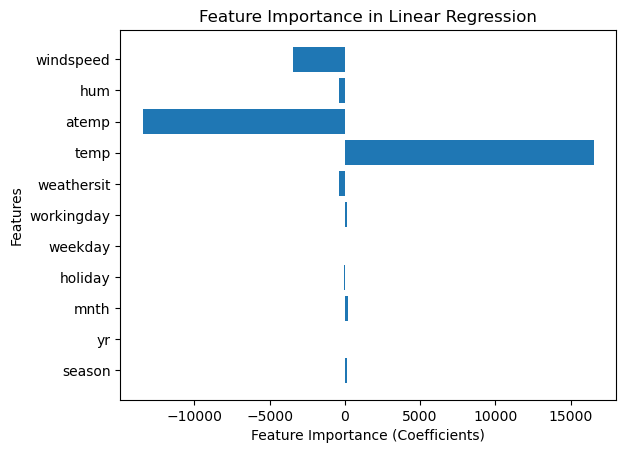

In [18]:
cols = list(train.drop('cnt', axis=1).columns)
plt.barh(cols, lr.coef_)
plt.xlabel('Feature Importance (Coefficients)')
plt.ylabel('Features')
plt.title('Feature Importance in Linear Regression')
plt.show()

<!-- ![Feature Importance](./images/linear-regression-feature-importance.png "Image by Author") -->

--- Insert Feature Importance Image ---

We can see that the `temp`, `atemp`, and `windspeed` features are the most important features. Let's create a test suite with only these features. We can also use the `dataset_drift_test` function to check if there is a drift in the what percentage of the important features.

In [19]:
important_features = ['temp', 'atemp', 'windspeed']
imp_features_drift_suite = test_drift_dataset_suite('important_features_drift_test',
                                                    important_features,
                                                    wrapped_ref_dataset)

imp_features_drift_suite_results = imp_features_drift_suite.run(actual_dataset=wrapped_curr_dataset,
                                                                reference_dataset=wrapped_ref_dataset)

dataset_drift_test(imp_features_drift_suite_results.results, threshold=1) # threshold=1 means all the features should pass the test

Executed 'Numerical drift (Kolmogorov-Smirnov)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'temp'}: 
               Test failed
               Metric: 0.0
                - [TestMessageLevel.ERROR] The data is drifting (p-value is equal to 0.0 and is below the test risk level 0.05) 
               
Executed 'Numerical drift (Kolmogorov-Smirnov)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7fbd1977e370>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7fbd2c99d610>, 'column_name': 'atemp'}: 
               Test failed
               Metric: 0.0
                - [TestMessageLevel.ERROR] The data is drifting (p-value is equal to 0.0 and is below the test risk level 0.05) 
               
Executed 'Numerical drift (Kolmogorov-Smirnov)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset 

{'passed': False, 'metric': 0.3333333333333333}

## Data vs/& Prediction Drift

Understanding the implications of drift test results on both input features and the target variable is crucial. What does it mean when these tests indicate different types of drift?

### Scenario 1: The input features have drifted but the target variable hasn't drifted. 

Should we be worried if the input features have drifted but the target variable hasn't drifted? There are two ways to interpret this:

1. The Model is Doing Fine: It might be that the model is strong enough to handle these changes in the input features. Machine learning models are built to find and use patterns, so they can often deal with some changes. Also, the changes might be happening in parts of the data that don’t really affect the model's predictions. This could mean our test for drift in the input is too sensitive to less important features.

2. There’s a Problem with the Model: The other possibility is that the model should be adjusting to these changes in the input features, but it’s not. This could mean the model isn’t strong enough to handle the changes. For example, the model might not be good at dealing with new kinds of data. In this case, we might need to retrain the model or make a new one.

### Scenario 2: The input features have not drifted but the target variable has drifted.

When the target variable changes but the input features don't, it's a clear sign that we need to investigate further. This situation usually points to a potential issue like a bug, a problem with data quality, or a drift detector that's not set up correctly.

In such cases, the model might become less accurate. This is because it's still using old patterns to make predictions, but the actual relationship between the inputs and outputs has changed. For instance, consider a model trained to predict video views based on the game played and video length. If the game and length stay the same but the number of views changes, it suggests that something else is influencing views now, which the model isn't catching.

### Scenario 3: The input features and the target variable have drifted.

When both the input features and the target variable show signs of drift, it usually suggests the model might be struggling with these changes. However, there are two possible interpretations:

- The Model is Handling the Drift Well: In this case, even though there's been a change in the input features, the model's output is adjusting appropriately. This indicates that the model is robust enough to handle the drift. While this is a positive sign, continuous monitoring of the model's performance is still necessary to ensure ongoing accuracy.

- The Model is Struggling with the Drift: Here, the model's predictions become unreliable and erratic because it can't cope with the changes in the input features. This suggests the model isn't robust enough. In such situations, it's crucial to investigate the cause of the drift. We may need to retrain or even rebuild the model to make it more adaptable to these changes.

## Conclusion

In this tutorial, we delved into various aspects of data drift, including its types and the tests available in Giskard to detect it. We learned how to build test suites tailored for different scenarios and the importance of selecting appropriate tests based on specific use cases. Additionally, we covered methods to test drift in the target variable and key features, along with strategies for interpreting test results effectively.

We encourage you to further explore Giskard and see how it can improve your model validation and testing processes.

If you found this helpful, consider giving us a star on Github and becoming part of our Discord community. We appreciate your feedback and hope Giskard becomes an indispensable tool in your quest to create superior ML models.

## Giskard + Grafana for Data Drift Monitoring

Now that we have our test suite ready, we can use Grafana to visualize the results of the test suite. The idea is to periodically run the test suite and store the results in a database. Then we can use Grafana to visualize the results. We'll be using the `postgres` database for this tutorial.

You can find all the code for this tutorial in this [Github Repository](https://github.com/sagar118/giskard-monitoring-tutorial).

### Setup Grafana and Postgres

We'll be using docker to setup Grafana, Postgres, and Adminer. We'll be using Adminer to interact with the Postgres database.

We'll be using the following docker-compose file to setup Grafana, Postgres, and Adminer.

```yaml
version: '3.7'

volumes:
    grafana_data: {}

networks:
    front-tier: {}
    back-tier: {}

services:
    db:
        image: postgres
        restart: always
        environment:
            POSTGRES_PASSWORD: postgres
        ports:
            - "5432:5432"
        networks:
            - back-tier

    adminer:
        image: adminer
        restart: always
        ports:
            - "8080:8080"
        networks:
            - front-tier
            - back-tier

    grafana:
        image: grafana/grafana
        restart: always
        user: "472"
        ports:
            - "3000:3000"
        volumes:
            - ./config/grafana_datasources.yaml:/etc/grafana/provisioning/datasources/datasources.yaml:ro
            - ./config/grafana_dashboards.yaml:/etc/grafana/provisioning/dashboards/dashboards.yaml:ro
            - ./dashboards:/opt/grafana/dashboards
        networks:
            - front-tier
            - back-tier
```

The directory structure for this tutorial is as follows:

```bash
.
├── config
│   ├── grafana_dashboards.yaml
│   └── grafana_datasources.yaml
├── dashboards
│   └── metrics.json
├── data
│   ├── raw_data.parquet
│   └── reference_data.parquet
├── docker-compose.yaml
├── model
│   └── lr_model.pkl
├── notebook
│   └── giskard-monitoring-metrics.ipynb
└── src
    ├── __pycache__
    ├── db.py
    ├── giskard_drift_test_suites.py
    └── main.py
```

The `grafana_datasources.yaml` file contains the configuration for the Postgres database. The `grafana_dashboards.yaml` file contains the configuration for the dashboard. The `metrics.json` file contains the details of the dashboard.

The `data` directory contains the raw data and the reference data. The `model` directory contains the model we trained earlier. The `src` directory contains the source code for this tutorial.

We'll be using the `docker-compose.yaml` file to setup Grafana, Postgres, and Adminer. We'll be using the `db.py` file to interact with the Postgres database. The `giskard_drift_test_suites.py` file contains the test suite we created earlier. The `main.py` file contains the code to run the test suite and store the results in the database.

To setup Grafana, Postgres, and Adminer we can run the following command:

```bash
docker-compose up -d
```

To stop the containers we can run the following command:

```bash
docker-compose stop
```

Once, the containers are up and running we can access Grafana at `http://localhost:3000/` and Adminer at `http://localhost:8080/`.

To access the Postgres database we can use the following credentials: username: `postgres`, password: `postgres`, database: `giskard_monitoring`.

To access the Grafana dashboard we can use the following credentials: username: `admin`, password: `grafana`.

We'll try to mock the production environment by using the `raw_data.parquet` file. We'll use the `reference_data.parquet` file as the reference data. Periodically we'll run the test suite on the five slices of the `raw_data.parquet` file each with 100 rows. We'll store the results of the test suite in the Postgres database. Then we'll use Grafana to visualize the results.

To run the test suite and store the results in the database we can run the following command in the root directory of the project:

```bash
python src/main.py
```